In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

1. Загружаем тестовые данные

In [127]:
# Загрузка тестовых данных
test_df = pd.read_excel('data/excel/test.xlsx')

2. Загружаем обученную модель

In [128]:
# Загрузка модели
model = xgb.XGBRegressor()
model.load_model("xgboost_model.json")  # Загружаем обученную модель

3. Подготавливаем признаки

In [129]:
if 'dt' in test_df.columns:
    test_df["dt"] = pd.to_datetime(test_df["dt"])
    test_df["year"] = test_df["dt"].dt.year
    test_df["month"] = test_df["dt"].dt.month
    test_df["day"] = test_df["dt"].dt.day
    test_df["quarter"] = test_df["dt"].dt.quarter
    test_df["day_of_week"] = test_df["dt"].dt.dayofweek
    test_df["day_of_month"] = test_df["dt"].dt.day

if 'Price' in test_df.columns:
    test_df["Price_source"] = test_df["Price"].shift(1)
    test_df["Price_Diff"] = test_df["Price"].diff()
    test_df["Price_source"].fillna(test_df["Price_source"].mean(), inplace=True)
    test_df["Price_Diff"].fillna(test_df["Price_Diff"].mean(), inplace=True)

# Генерация лагов
for i in [1, 2, 3, 6, 12]:
    test_df[f"lag_{i}"] = test_df["Price"].shift(i)

# Добавляем статистические признаки (скользящее стандартное отклонение)
test_df["rolling_std"] = test_df["Price"].rolling(window=3).std()

C:\Users\Виктор\AppData\Local\Temp\ipykernel_12424\464485494.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df["Price_source"].fillna(test_df["Price_source"].mean(), inplace=True)
C:\Users\Виктор\AppData\Local\Temp\ipykernel_12424\464485494.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [130]:
# Нормализованные цены
test_df["normalized_price"] = (test_df["Price"] - test_df["Price"].mean()) / test_df["Price"].std()
test_df["log_normalized_price"] = np.log1p(test_df["normalized_price"].abs()) * np.sign(test_df["normalized_price"])

# Заполняем пропущенные значения
test_df.fillna(method="bfill", inplace=True)
test_df.fillna(0, inplace=True)  # На случай, если bfill не сработал

C:\Users\Виктор\AppData\Local\Temp\ipykernel_12424\1322922813.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df.fillna(method="bfill", inplace=True)


4. Выбираем признаки и делаем прогноз

In [131]:
# Подготовка тестовых данных (порядок фичей как в обучении!)
feature_columns = [
    "year", "month", "quarter", "day_of_week", "day_of_month",
    "rolling_std", "normalized_price", "log_normalized_price", "day",
    "lag_1", "lag_2", "lag_3", "lag_6", "lag_12"
]
X_test = test_df[feature_columns]

# Прогнозирование
test_df["Прогноз_цены"] = model.predict(X_test)

5. Определяем N недель закупки

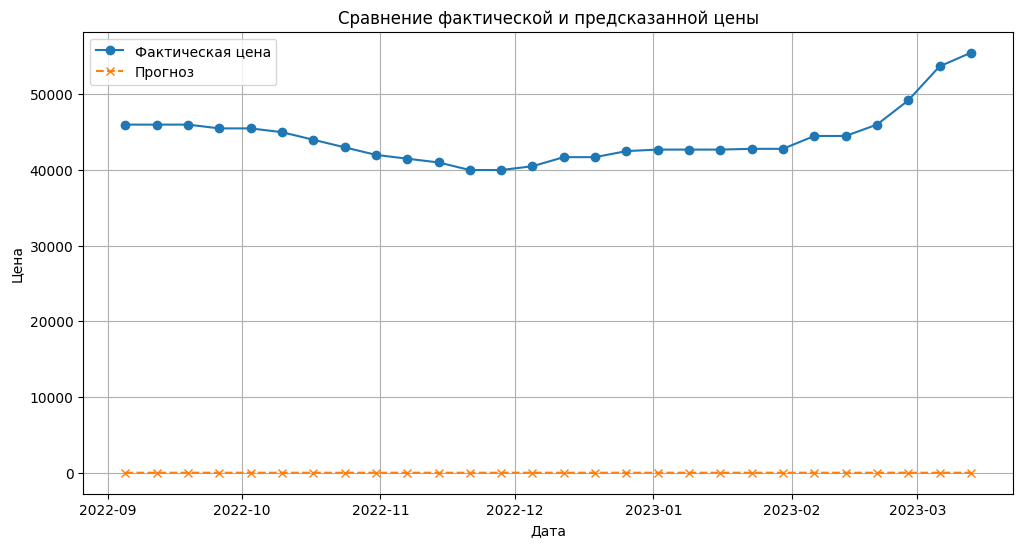

In [132]:
# Визуализация фактических и предсказанных цен
plt.figure(figsize=(12, 6))
plt.plot(test_df["dt"], test_df["Price"], label="Фактическая цена", marker='o')
plt.plot(test_df["dt"], test_df["Прогноз_цены"], label="Прогноз", linestyle='dashed', marker='x')
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Сравнение фактической и предсказанной цены")
plt.grid()
plt.show()

In [133]:
# Проверка распределения закупки
def calculate_weeks(row):
    if row["Прогноз_цены"] > row["Price"] * 1.02:
        return 6
    elif row["Прогноз_цены"] > row["Price"]:
        return 4
    elif row["Прогноз_цены"] < row["Price"] * 0.98:
        return 1
    else:
        return 3

test_df["Закупка_недель"] = test_df.apply(calculate_weeks, axis=1)

# Анализ распределения решений по закупке
print(test_df["Закупка_недель"].value_counts())

Закупка_недель
1    28
Name: count, dtype: int64


6. Сохраняем результаты

In [134]:
print("Обучающие признаки:", model.feature_names_in_)
print("Признаки в тесте:", list(X_test.columns))

Обучающие признаки: ['year' 'month' 'quarter' 'day_of_week' 'day_of_month' 'rolling_std'
 'normalized_price' 'log_normalized_price' 'day' 'lag_1' 'lag_2' 'lag_3'
 'lag_6' 'lag_12']
Признаки в тесте: ['year', 'month', 'quarter', 'day_of_week', 'day_of_month', 'rolling_std', 'normalized_price', 'log_normalized_price', 'day', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']


In [135]:
print(X_test.describe())

              year      month    quarter  day_of_week  day_of_month  \
count    28.000000  28.000000  28.000000         28.0     28.000000   
mean   2022.392857   7.035714   2.678571          0.0     15.857143   
std       0.497347   4.459548   1.415616          0.0      8.788521   
min    2022.000000   1.000000   1.000000          0.0      2.000000   
25%    2022.000000   2.000000   1.000000          0.0      8.500000   
50%    2022.000000   9.000000   3.000000          0.0     15.000000   
75%    2023.000000  11.000000   4.000000          0.0     23.250000   
max    2023.000000  12.000000   4.000000          0.0     31.000000   

       rolling_std  normalized_price  log_normalized_price        day  \
count    28.000000      2.800000e+01             28.000000  28.000000   
mean    773.384738     -1.586033e-17             -0.052060  15.857143   
std     935.101420      1.000000e+00              0.582581   8.788521   
min       0.000000     -1.165676e+00             -0.772733   2.00000

In [136]:
print("Мин/Макс обучающих данных:", model.get_booster().feature_names)
print("Мин/Макс теста:", X_test.min().min(), X_test.max().max())

Мин/Макс обучающих данных: ['year', 'month', 'quarter', 'day_of_week', 'day_of_month', 'rolling_std', 'normalized_price', 'log_normalized_price', 'day', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']
Мин/Макс теста: -1.1656764771747683 53700.0


In [137]:
# Сохранение результатов
test_df.to_excel("predicted_procurement.xlsx", index=False)
print("Прогнозирование завершено. Результаты сохранены в predicted_procurement.xlsx")

Прогнозирование завершено. Результаты сохранены в predicted_procurement.xlsx
